# Setup

In [1]:
# Imports
%matplotlib inline
import copy
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import shutil
import os
import io
import logomaker
import math

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from copy import deepcopy
from itertools import combinations, chain, product, permutations
from math import log
from matplotlib.colors import LogNorm, Normalize
from matplotlib import transforms
from matplotlib.transforms import Bbox
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter
from PIL import Image
from scipy.stats import chisquare, fisher_exact
from scipy import ndimage

In [2]:
# Paths
CLUSTERS_DIR = Path('../../all_clusters/')
STRUCTURES_DIR = Path('../../all_structures/')
DATA_DIR = Path('data/')
FRAGMENTS_DIR = Path('data/fragments/')
FRAGMENTS_RANGE = [8, 24] # range(24, 105, 20)
FIGURES_DIR = Path('figures/')
TRAINING_DATA_DIR = Path('training_data/622/')
METADATA = pd.read_csv(DATA_DIR/'RCSB_metadata.csv', header=[1]).dropna(axis=1, how='all')

# Create figures directory if none exists
if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load all data

# Tetraloops
tloops = utils.load(DATA_DIR/'tloops.pickle')

# Annotated chains
chains_annotated = utils.load(DATA_DIR/'chains_annotated.pickle')

# Fragments
for i in FRAGMENTS_RANGE:
    globals()[f"fragments_{i}"] = utils.load(FRAGMENTS_DIR/f"fragments_{i}.pickle")
fragments = [val for key, val in globals().items() if "fragments" in key]

In [4]:
# General functions

def get_pdb_ids(data, unique=False, clusters=None):
    if clusters: pdb_ids = [i.pdb_id for i in data if i.clust_id in clusters]
    else: pdb_ids = [i.pdb_id for i in data]
    if unique: return set(pdb_ids)
    else: return pdb_ids


def get_seqs(data, unique=False, clusters=None):
    if clusters: seqs = [i.res_seq for i in data if i.clust_id in clusters]
    else: seqs = [i.res_seq for i in data]
    if unique: return list(set(seqs))
    else: return seqs


def get_counter_dict(data):
    return OrderedDict(Counter(data).most_common())


def get_res_num_labels(seq_len, as_dict=False):
    flanking_len = (seq_len - 4)//2
    labels = list(range(-flanking_len, 0)) + [f"T{i}" for i in range(1, 5)] + [f"+{i}" for i in range(1, flanking_len + 1)]
    if as_dict: return dict(zip(range(seq_len), labels))
    else:       return labels


def get_structure(pdb_id: str):
    matching_rows = METADATA[METADATA['Entry ID'] == pdb_id.upper()]
    if not matching_rows.empty:
        return matching_rows.iloc[0]["Stucture Keywords"]
    else:
        return ""


def get_organisms(pdb_id: str):
    organisms = []
    start_loc = METADATA.index[METADATA['Entry ID'] == pdb_id.upper()]
    if not start_loc.any(): return set(["N/A"])
    start_idx = start_loc.tolist()[0]
    for index, row in METADATA.iloc[start_idx:].iterrows():
        if row['Entry ID'] == pdb_id.upper() or pd.isna(row['Entry ID']):
            organisms += [str(row["Source Organism"])]
        else: break
    return set([i for i in organisms if i != "nan"])


def format_e(n, decimals=1):
    e = f'{n:.{decimals}e}'.split('e')
    if len(e) != 2: return 'NAN'
    if e[1] == '+00': e = e[0]
    else:             e = f'{e[0]}e{int(e[1])}'
    return e

In [5]:
# pyplot config

COLORS = plt.cm.Set2.colors + plt.cm.Set1.colors + plt.cm.Set3.colors
HATCHES = ["//", "\\\\", ".."  , "++" , "-" , "|" , "x", "*" ]

plt.style.use('seaborn-darkgrid')
# custom_cycler = plt.cycler(hatch=HATCHES) + plt.cycler(color=COLORS)
custom_cycler = plt.cycler(color=COLORS)
plt.rcParams["axes.prop_cycle"] = custom_cycler
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['hatch.color'] = 'w'

# Metadata

## Structures

In [ ]:
# Config
BAR_HEIGHT = 0.4
NAMED_STRUCTS = {"Ribosome-associated": "ribosome", "RNA-associated": "rna"} # Regrouped structure category names and their associated keywords
OTHER_STRUCT_LIMIT = 20 # The number of tetraloops below which a structure is binned into "Other"

In [ ]:
def regroup_structures(data, groups=[]):
    structs = get_counter_dict([get_structure(i).lower() for i in get_pdb_ids(data)])
    if groups: regrouped_structs = dict(zip(groups, np.zeros(len(groups))))
    else:      regrouped_structs = dict(zip(list(NAMED_STRUCTS.keys()) + ["Other"], np.zeros(len(NAMED_STRUCTS)+1)))
    for structure, count in structs.items():
        for group_name, keyword in NAMED_STRUCTS.items():
            if keyword in structure:       regrouped_structs[group_name] += count; break
        else:
            if count < OTHER_STRUCT_LIMIT: regrouped_structs["Other"] += count
            else:                          regrouped_structs[structure.capitalize()] = count
    if not groups:
        regrouped_structs = dict(sorted(regrouped_structs.items(), key=lambda item: item[1]))
        regrouped_structs = {'Other': regrouped_structs.pop('Other'), **regrouped_structs} # Move "Other" category to back
    return regrouped_structs

In [ ]:
bottaro_structs = regroup_structures(tloops)
generated_structs = regroup_structures([i for i in fragments_8 if i.clust_id != 0], groups=list(bottaro_structs.keys()))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
fig.subplots_adjust(wspace=0.3)
fig.tight_layout()

ax.set_title("Structural annotation associated with the PDB entry of each tetraloop")
ax.set_ylabel("Annotated structure")
ax.set_xlabel("Number of tetraloops")
ax.set_xlim([0, 19000])

y_pos = np.arange(len(bottaro_structs))
_ = ax.set_yticks(y_pos, labels=bottaro_structs.keys())
bar = ax.barh(y_pos, bottaro_structs.values(), height=BAR_HEIGHT, align="edge", hatch=HATCHES[0])
ax.bar_label(bar, padding=5)
bar = ax.barh(y_pos, generated_structs.values(), height=-BAR_HEIGHT, align="edge", hatch=HATCHES[1])
ax.bar_label(bar, padding=5)

ax.legend(labels=["Bottaro", "Generated"], loc="lower right")

fig.savefig(FIGURES_DIR/"structures.png", bbox_inches='tight', dpi=300)

### Chain length vs. structure

In [ ]:
NUM_BINS = 20

In [ ]:
chain_lengths = [len(i) for i in chains_annotated]
bin_lims = np.linspace(min(chain_lengths), max(chain_lengths), num=NUM_BINS+1)
bin_size = bin_lims[1] - bin_lims[0]

chain_bins = [[] for i in range(NUM_BINS)]
for chain in chains_annotated:
    bin_idx = int((len(chain))/bin_size)
    if bin_idx == NUM_BINS: bin_idx -= 1
    chain_bins[bin_idx] += [chain]

size_counts = {"Ribosomes": np.zeros(NUM_BINS), "RNAs": np.zeros(NUM_BINS), "Other": np.zeros(NUM_BINS)} 

# TODO fix these categories?
for bin_idx, bin in enumerate(chain_bins):
    for chain in bin:
        structure = get_structure(chain.pdb_id).lower()
        if "ribosome" in structure: size_counts["Ribosomes"][bin_idx] += 1
        elif "rna" in structure:    size_counts["RNAs"][bin_idx] += 1 #? what does "RNA" mean? just "non-ribosomal"?
        else:                       size_counts["Other"][bin_idx] += 1

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), dpi=300)

ax.set_title("Structural annotation vs. chain length")
ax.set_xlabel("Chain length (nt)")

bottom = np.zeros(NUM_BINS)
for idx, (boolean, size_count) in enumerate(size_counts.items()):
    bars = ax.bar(bin_lims[:-1], size_count, width=bin_size, label=boolean, bottom=bottom, align='edge', hatch=HATCHES[idx])
    # ax.bar_label(bars, [int(i) if i > 30 else "" for i in size_count], padding=5)
    bottom += size_count

ax.legend(loc="upper right")
fig.savefig(FIGURES_DIR/"structure_proportions_v_chain_length.png", bbox_inches='tight')

#! bottaro says it's all ribosomes so these categories may be meaningless?

## Organisms

In [ ]:
# Config
BAR_HEIGHT = 0.4
NAMES_ORGS = {"T. thermophilus": "thermus thermophilus", "E. coli": "escherichia coli", "S. cerevisiae": "saccharomyces cerevisiae"}
OTHER_ORG_LIMIT = 200 # The number of tetraloops below which an organism is binned into "Other"

In [ ]:
def regroup_organisms(data, groups=[]):
    orgs = get_counter_dict([j.lower() for i in get_pdb_ids(data) for j in get_organisms(i)])
    if groups: regrouped_orgs = dict(zip(groups, np.zeros(len(groups))))
    else:      regrouped_orgs = dict(zip(list(NAMES_ORGS.keys()) + ["Other"], np.zeros(len(NAMES_ORGS)+1)))
    for organism, count in orgs.items():
        for group_name, keyword in NAMES_ORGS.items():
            if keyword in organism:     regrouped_orgs[group_name] += count; break
        else:
            if count < OTHER_ORG_LIMIT: regrouped_orgs["Other"] += count
            else:
                generic = organism.capitalize().split()[0][0] + ". "
                species = " ".join(organism.split()[1:])
                name = generic + species if organism != "synthetic construct" else organism.capitalize()
                regrouped_orgs[name] = count
    if not groups:
        regrouped_orgs = dict(sorted(regrouped_orgs.items(), key=lambda item: item[1]))
        regrouped_orgs = {'Other': regrouped_orgs.pop('Other'), **regrouped_orgs} # Move "Other" category to back
    return regrouped_orgs

In [ ]:
bottaro_organisms = regroup_organisms(tloops)
generated_organisms = regroup_organisms([i for i in fragments_8 if i.clust_id != 0], groups=list(bottaro_organisms.keys()))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
fig.subplots_adjust(wspace=0.3)
fig.tight_layout()

ax.set_title("Organism annotation associated with the PDB entry of each tetraloop")
ax.set_ylabel("Annotated organism")
ax.set_xlabel("Number of tetraloops")
ax.set_xlim([0, 15000])

y_pos = np.arange(len(bottaro_organisms))
_ = ax.set_yticks(y_pos, labels=[f"$\it{'{'+i+'}'}$" if i not in ["Synthetic construct", "Other"] else i for i in bottaro_organisms.keys()])
bar = ax.barh(y_pos, bottaro_organisms.values(), height=BAR_HEIGHT, align="edge", hatch=HATCHES[0])
ax.bar_label(bar, padding=5)
bar = ax.barh(y_pos, generated_organisms.values(), height=-BAR_HEIGHT, align="edge", hatch=HATCHES[1])
ax.bar_label(bar, padding=5)

ax.legend(labels=["Bottaro tetraloops", "Generated tetraloops"], loc="lower right")

fig.savefig(FIGURES_DIR/"organisms.png", bbox_inches='tight', dpi=300)


# Residue composition

## Config

In [15]:
PLOT_TITLE = "GNRA-like"
FILE_PREFIX = "gnralike"

RES_FRAGS = [i for i in fragments_24 if i.clust_id in [1, 3, 6, 9, 25, 26, 36, 40]] #!
# GNRA: 1
# GNRA-like: 1, 3, 6, 9, 25, 26, 36, 40
# UNCG: 2
# UNCG-like: 2, 5, 37, 44

#! Exclude ribosomal structures
# RES_FRAGS = [i for i in RES_FRAGS if "ribosome" not in get_structure(i.pdb_id).lower()]

In [16]:
seqs = get_seqs(RES_FRAGS, unique=True)
seq_all = "".join(seqs)
residues = sorted(list(set(seq_all)))
seq_len = len(seqs[0])
tloop_pos = int(seq_len/2-2)
flanking_len = (seq_len-4)//2

pos_pairs = list(combinations(range(seq_len), 2))
pos_pairs_antid = list(zip(range(seq_len), reversed(range(seq_len))))[:(seq_len//2)-2][::-1]
pos_pairs_tloop = list(combinations(range(tloop_pos, tloop_pos+4), 2))

# Upper triangular matrix indices
ax_coords_full = np.ravel_multi_index(np.triu_indices(seq_len, k=1), dims=(seq_len, seq_len))
ax_coords_tloop = np.ravel_multi_index(np.triu_indices(3), dims=(3, 3))

# Diagonal indices
ax_coords_full_diag = np.ravel_multi_index(np.diag_indices(seq_len), (seq_len, seq_len))
ax_coords_tloop_diag = np.ravel_multi_index(np.diag_indices(3), (3, 3))

res_pairs = list(product(residues, residues)) # list(permutations(residues, 2))
res_pair_labels_dict = dict(zip(res_pairs, [f"{i[0]}_{i[1]}" for i in res_pairs]))
res_num_labels = get_res_num_labels(seq_len)
res_num_labels_dict = get_res_num_labels(seq_len, True)
clust_ids = list(set([i.clust_id for i in RES_FRAGS]))

In [17]:
# Functions

# Draw tetraloops highlight box
def plot_tloop_rect(ax, rect_pos=None, rect_size=None, fc=None, lw=2, ec="black", z=1, text_pos=None, text_color="black", text_bg=None):
    ymin, ymax = ax.get_ylim()
    if not rect_pos:  rect_pos = (tloop_pos-0.5, ymin)
    if not rect_size: rect_size = (4, ymax)

    rect = patches.Rectangle(rect_pos, rect_size[0], rect_size[1], fc=fc, fill=True if fc else False, lw=lw*2, ec=ec, zorder=z)
    ax.add_patch(rect)
    rect.set_clip_path(rect)
    
    if not text_pos: text_pos = (tloop_pos+1.5, ymax-0.05)
    ax.text(text_pos[0], text_pos[1], "Tetraloop", ha='center', va='center', color=text_color, backgroundcolor=text_bg if text_bg else '#00000000')


# Plot p-values
def plot_pvals(ax, pvals, threshold=0.05, show_text=True, text_pos=None, text_bg="white"):
    
    ax.set_ylabel("-log10(p-value)", rotation=-90, labelpad=15)
    ax.tick_params(axis='y', which='both', right=False)
    ax.set_yscale('log', base=1/10) # Same as -log_10(x)

    pvals_sig  = [(pos, pval) for pos, pval in enumerate(pvals) if pval < threshold]
    if pvals_sig:  ax.scatter([i[0] for i in pvals_sig], [i[1] for i in pvals_sig], c='red')

    pvals_nsig = [(pos, pval) for pos, pval in enumerate(pvals) if pval >= threshold]
    if pvals_nsig: ax.scatter([i[0] for i in pvals_nsig], [i[1] for i in pvals_nsig], c='grey')

    ax.plot(ax.get_xlim(), (threshold, threshold), c='grey', ls='--', lw=2, zorder=-1)    

    if show_text:
        if not text_pos: text_pos = (ax.get_xlim()[0], threshold+0.04)
        ax.text(text_pos[0], text_pos[1], f"p-value threshold: {format_e(threshold)}", backgroundcolor=text_bg if text_bg else '#00000000', va='bottom')


def hide_empty_axes(axes):
    for ax in axes.flatten():
        if not ax.has_data():
            ax.axis('off')


def disable_axes(axes):
    for ax in axes.flatten():
        ax.axis('on')
        ax.set_facecolor('lightgray')
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.grid(False)


def add_global_ticks(fig, xticks, yticks, fontsize=12):
    ax_global = fig.add_subplot(111, frameon=False)
    ax_global.tick_params(labeltop=True, labelbottom=False, pad=20)
    
    # Set xticks
    ax_global.set_xticks(np.append(np.array(range(len(xticks)))+0.5, len(xticks)))
    ax_global.set_xticklabels(xticks + [""], fontsize=fontsize)

    # Set yticks
    ax_global.set_yticks(np.append(np.array(range(len(yticks)))+0.5, len(yticks)))
    ax_global.set_yticklabels(yticks + [""], fontsize=fontsize)
    ax_global.invert_yaxis()

    ax_global.grid(False)
    ax_global.set_zorder(-1)

## Mutual information

In [67]:
def calculate_mutual_information(data_x, data_y):
    data_xy = list(zip(data_x, data_y))
    x_vals, y_vals = set(data_x), set(data_y)
    
    i = 0
    for x_val, y_val in product(x_vals, y_vals):
        p_x = data_x.count(x_val)/len(data_x)
        p_y = data_y.count(y_val)/len(data_y)
        p_j = data_xy.count((x_val, y_val))/len(data_xy)
        i_j = p_j*log(p_j/(p_x*p_y), 2) if p_j else 0
        i += i_j
    return i

### Position-wise

In [68]:
pos_mi_arr = np.zeros((seq_len, seq_len))
for pos_1, pos_2 in pos_pairs:
    pos_1_seq = [i[pos_1] for i in seqs]
    pos_2_seq = [i[pos_2] for i in seqs]
    mi = calculate_mutual_information(pos_1_seq, pos_2_seq)
    pos_mi_arr[pos_1, pos_2] = mi
pos_mi_arr[np.tril_indices(pos_mi_arr.shape[0])] = None

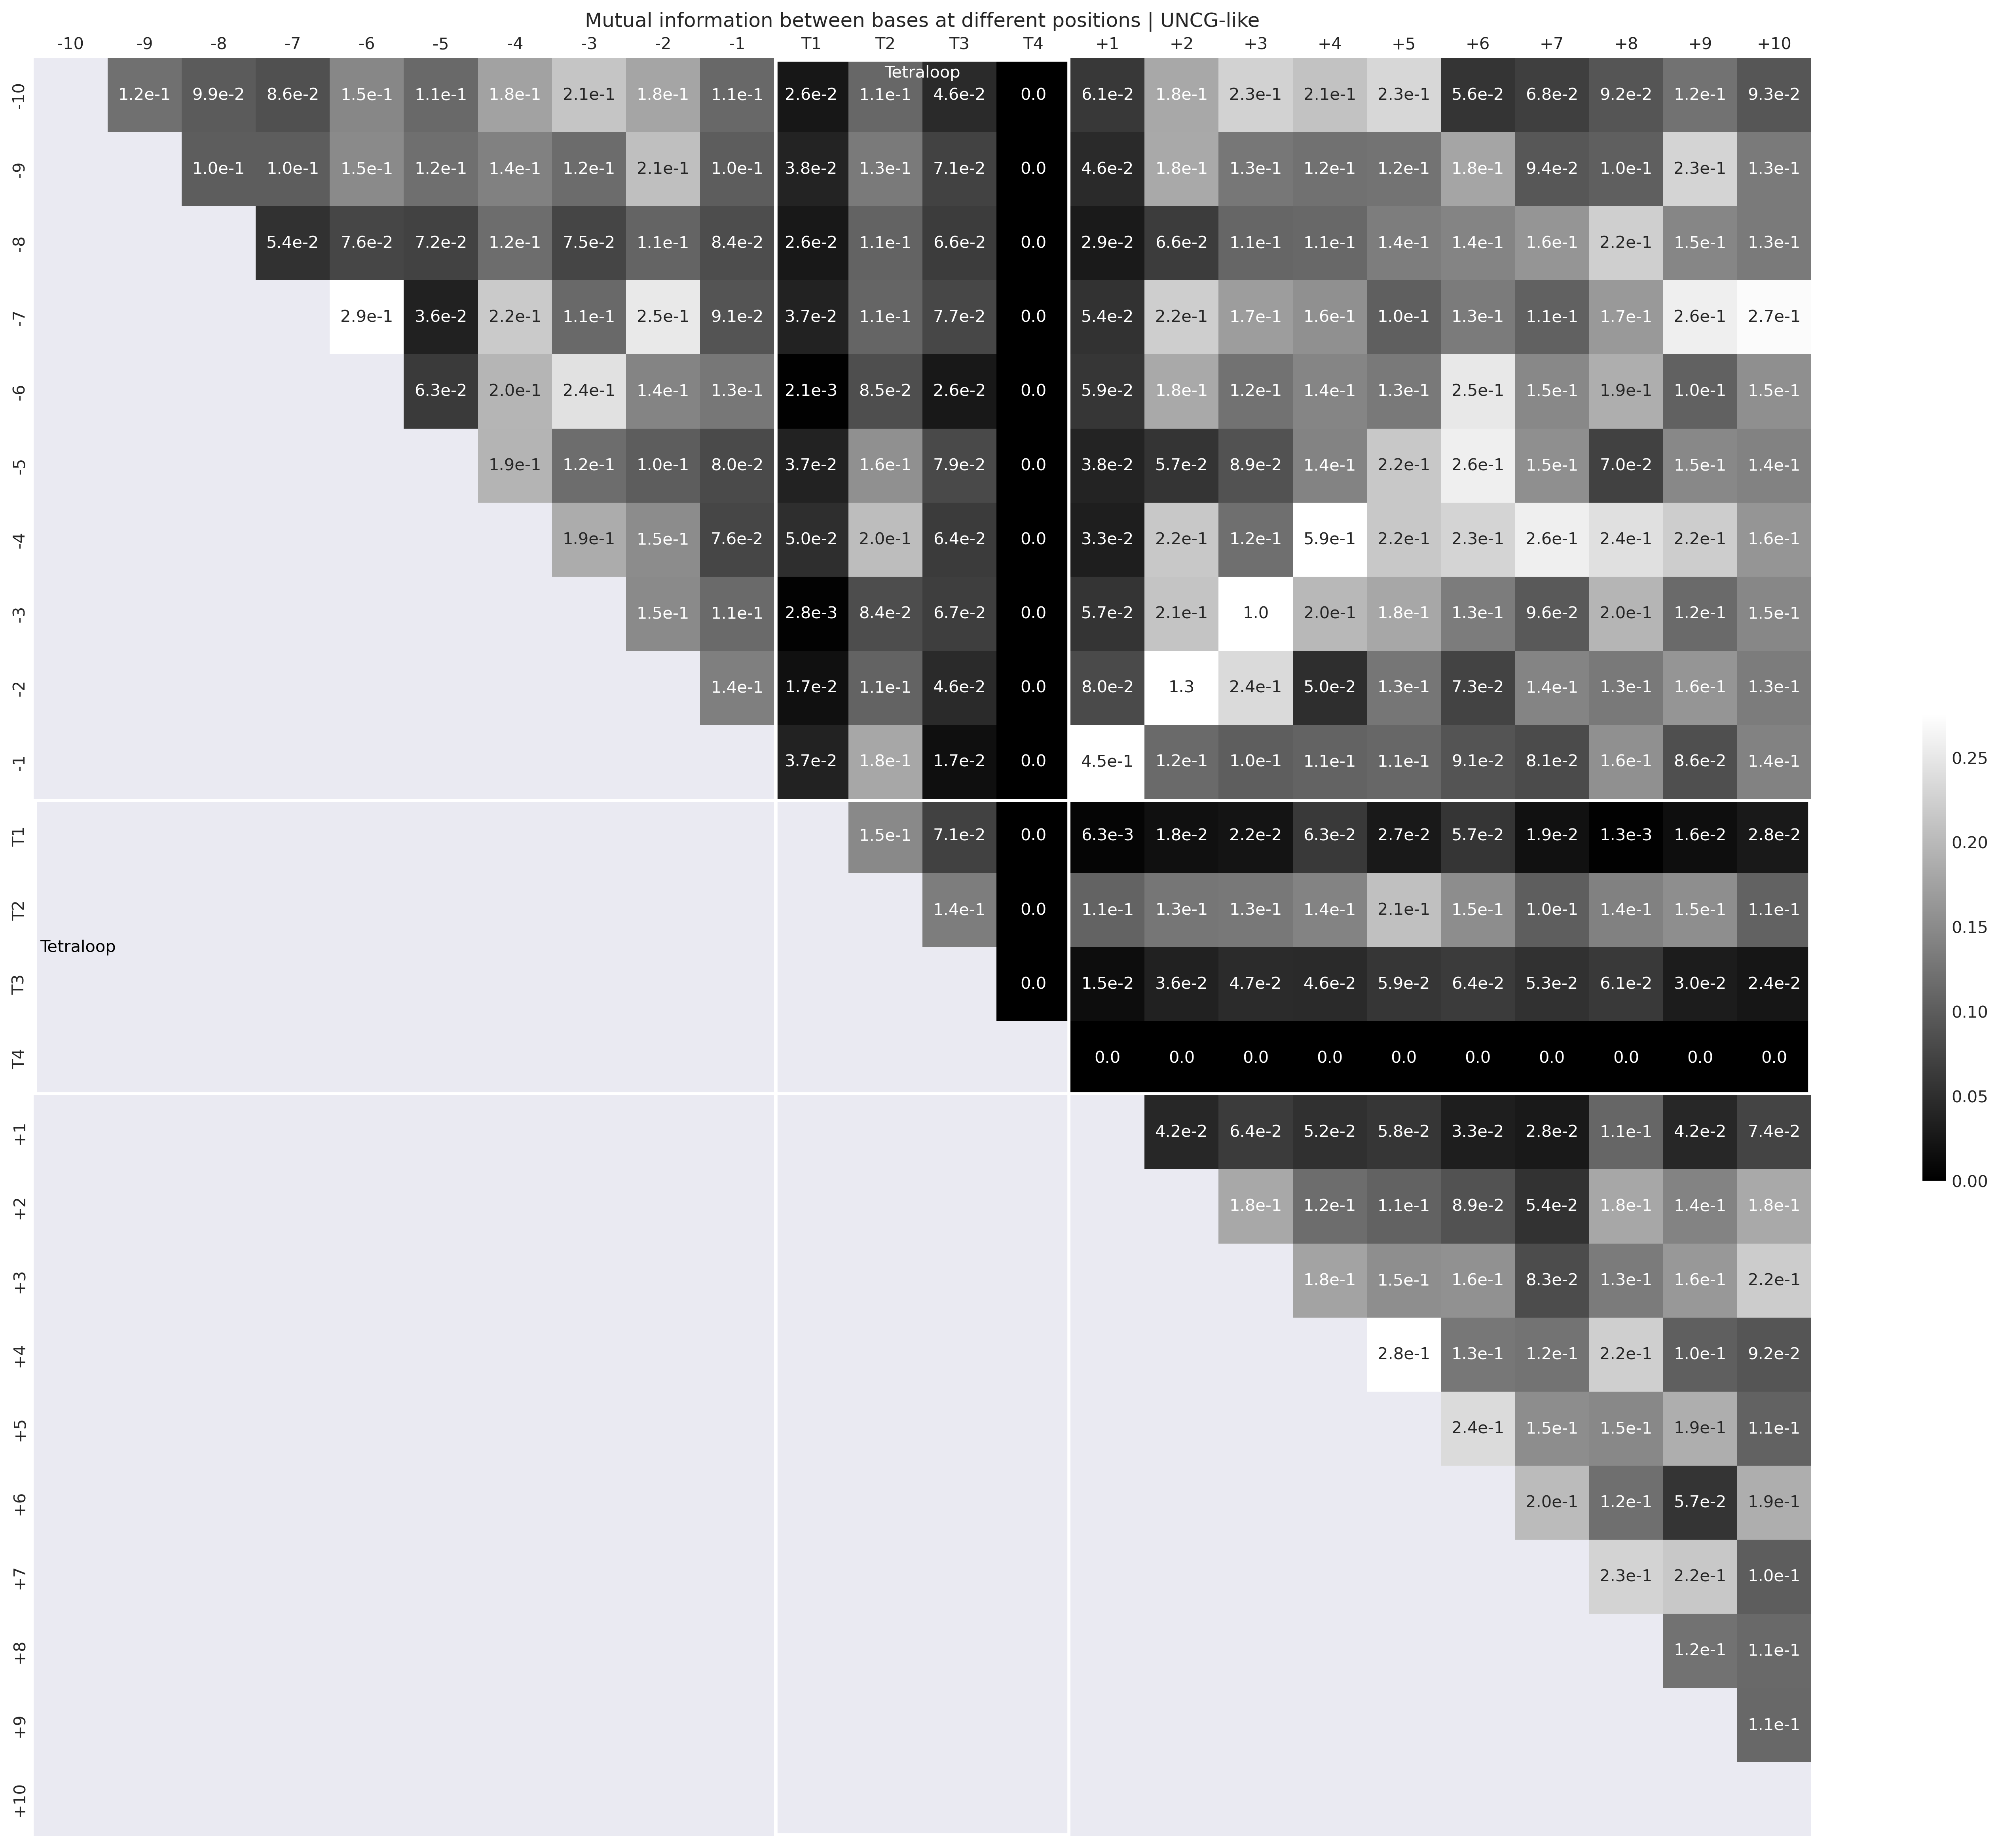

In [69]:
# Full plot

fig, ax = plt.subplots(figsize=(0.8*seq_len,0.8*seq_len), dpi=300)
ax.set_title(f"Mutual information between bases at different positions | {PLOT_TITLE}")
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, labeltop=True)

labels = np.stack(np.vectorize(format_e)(pos_mi_arr), axis=0)

sns.heatmap(
    pos_mi_arr, ax=ax,
    robust=True, # Colormap range is computed with robust quantiles instead of the extreme values
    annot=labels, xticklabels = res_num_labels, yticklabels = res_num_labels,
    square=True, fmt="", cbar_kws={"shrink": 5/seq_len}, cmap=mpl.cm.get_cmap('gray')
)

plot_tloop_rect(ax, rect_pos=(tloop_pos, 0), rect_size=(4, seq_len), text_pos=(tloop_pos+2, 0.2), ec="white", text_color="white")
plot_tloop_rect(ax, rect_pos=(0, tloop_pos), rect_size=(seq_len, 4), text_pos=(0.6, tloop_pos+2), ec="white", text_color="black")

fig.tight_layout()
fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_mi_pos_v_pos_full.png", bbox_inches='tight', dpi=300)

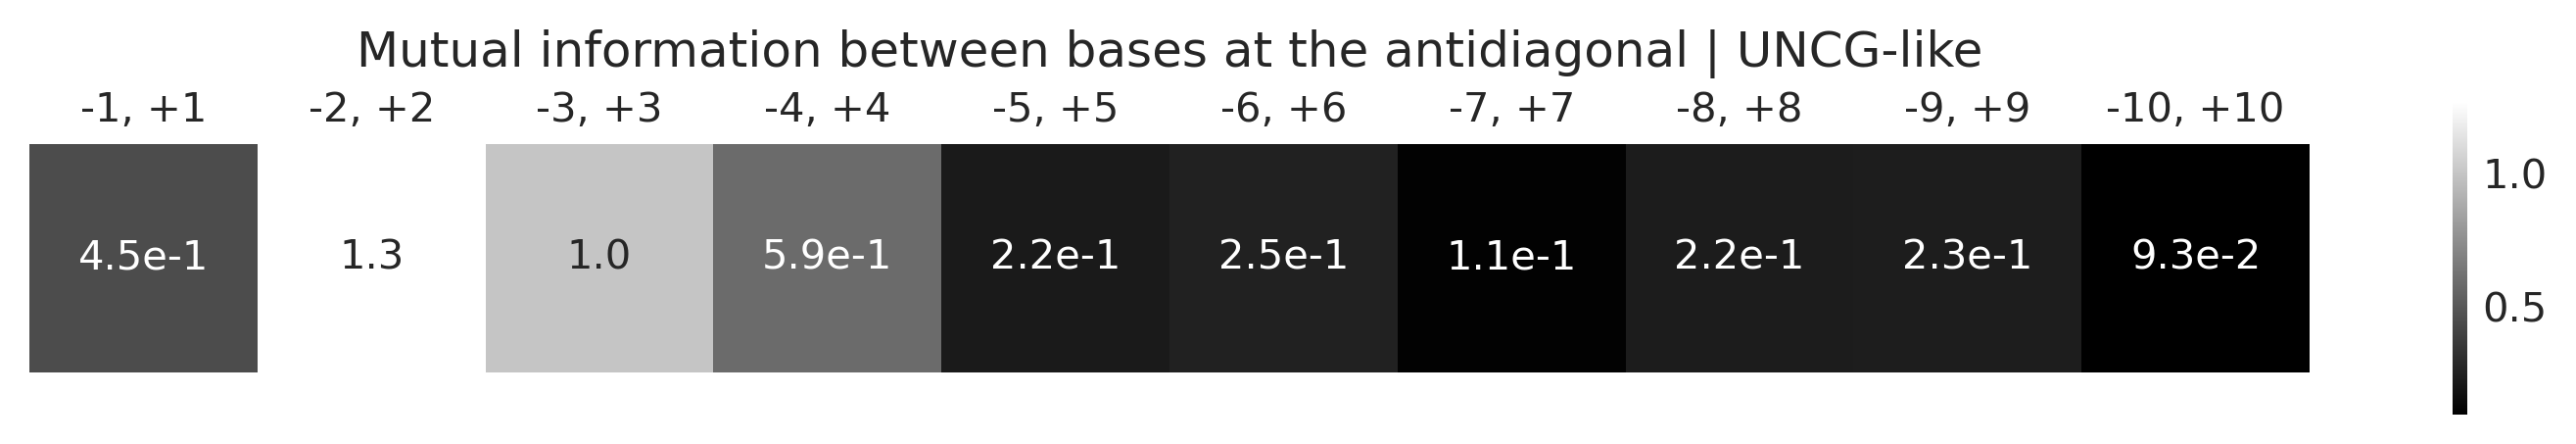

In [70]:
# Antidiagonal

fig, ax = plt.subplots(figsize=(1*len(pos_pairs_antid), 1.5), dpi=300)
ax.set_title(f"Mutual information between bases at the antidiagonal | {PLOT_TITLE}")
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, labeltop=True, left=False, labelleft=False)

pos_mi_ad = [pos_mi_arr[x, y] for x, y in pos_pairs_antid]
data_labels = [format_e(i) for i in pos_mi_ad]
tick_labels = [f"{res_num_labels_dict[x]}, {res_num_labels_dict[y]}" for x,y in pos_pairs_antid]

sns.heatmap(
    pd.DataFrame(pos_mi_ad).T, ax=ax,
    robust=True, # Colormap range is computed with robust quantiles instead of the extreme values
    annot=pd.DataFrame(data_labels).T, xticklabels = tick_labels,
    square=True, fmt="", cmap=mpl.cm.get_cmap('gray')
)

# plot_tloop_rect(ax, rect_pos=(0, 0), rect_size=(2, 1), text_pos=(1, 0.2), ec="red", text_color="white")

fig.tight_layout()
fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_mi_pos_v_pos_antidiagonal.png", bbox_inches='tight', dpi=300)

## Single

In [71]:
# per-position scores (Chi-squared)

single_scores_chi = []

f_exp = [seq_all.count(i)/seq_len for i in residues]
for pos in range(seq_len):
    pos_seq = [i[pos] for i in seqs]
    f_obs = [pos_seq.count(i) for i in residues]
    score = chisquare(f_obs, f_exp)
    single_scores_chi += [(score.statistic, score.pvalue)]

single_scores_pvals = [i[1] for i in single_scores_chi]

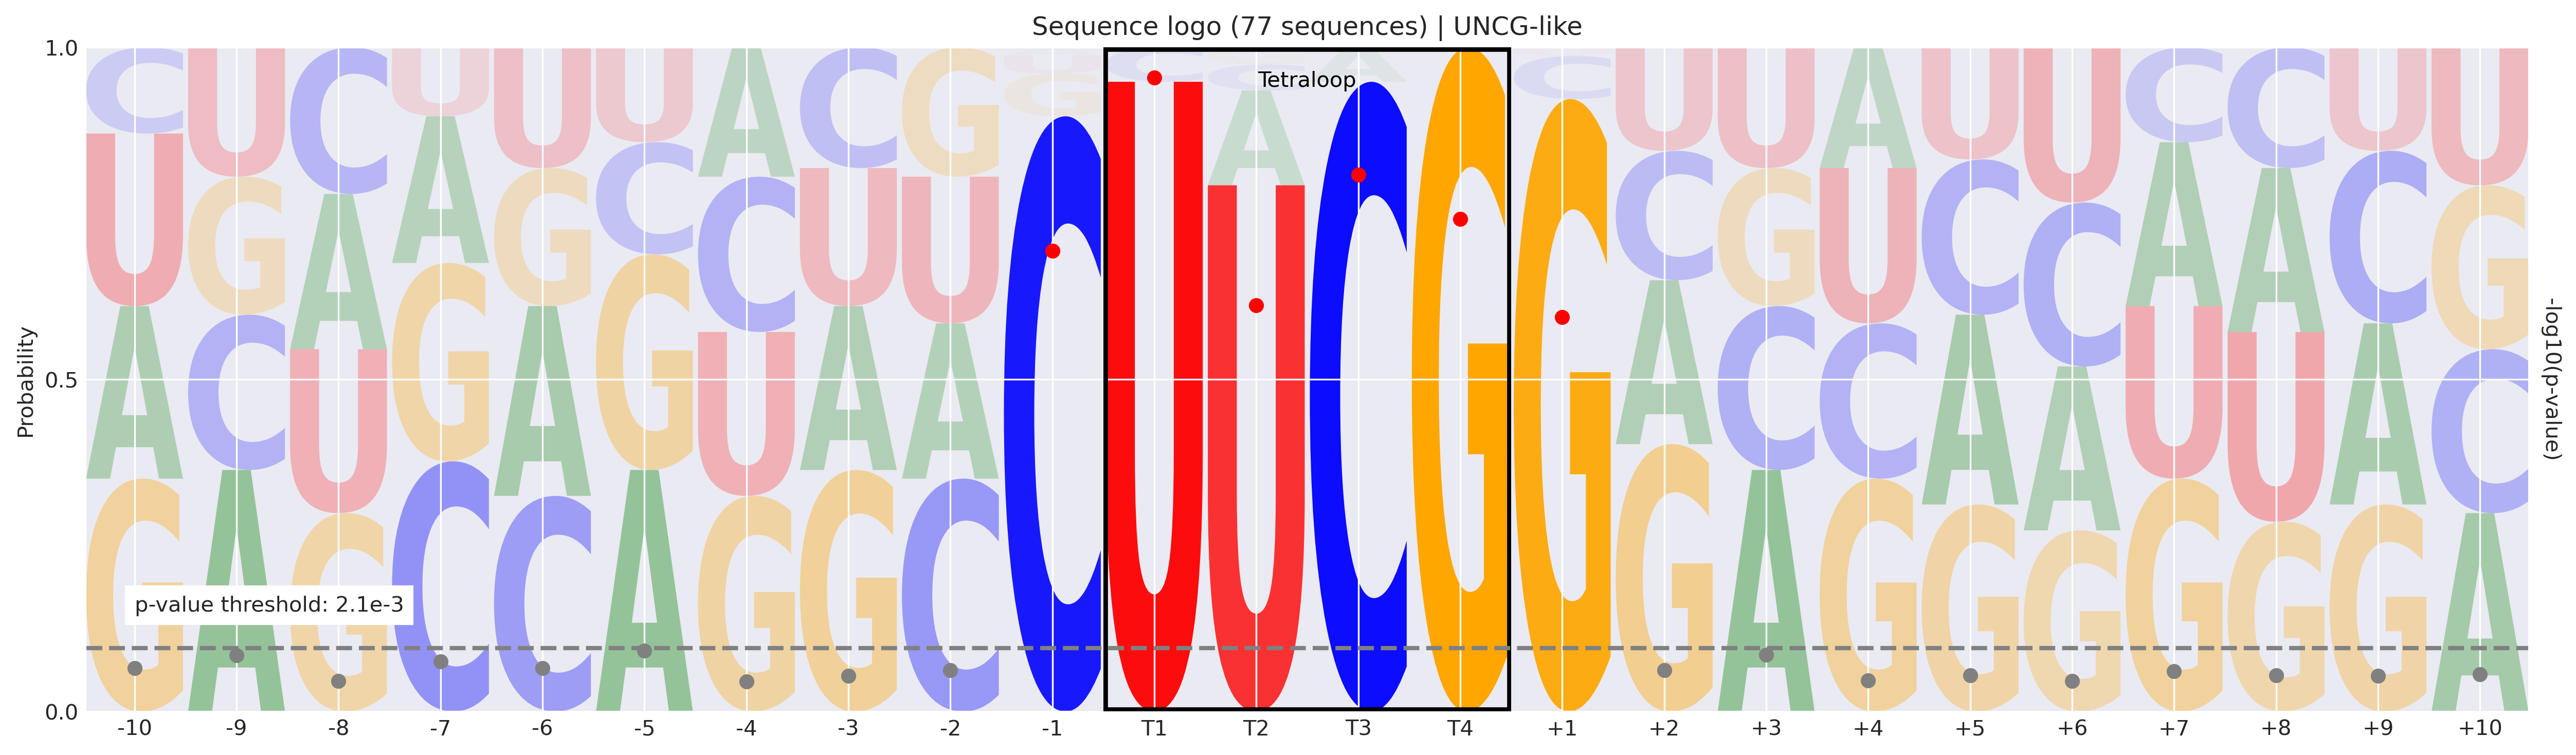

In [79]:
# Sequence logo

def plot_sequence_logo(ax, start_idx=0, stop_idx=seq_len, inverted=False):

    logo_len = stop_idx-start_idx
    pos_labels = res_num_labels[start_idx:stop_idx]

    # Get residue probabilities dataframe
    res_array = np.zeros(shape=(logo_len, len(residues)))
    for seq in seqs:
        logo_seq = seq[start_idx:stop_idx]
        for pos, res in enumerate(logo_seq):
            res_array[pos][residues.index(res)] += 1
    res_array = res_array/res_array.sum(axis=1, keepdims=True)
    res_df = pd.DataFrame(res_array, columns=residues)

    if inverted:
        res_df.index = reversed(range(logo_len))
        pos_labels = pos_labels[::-1]
        
    logo = logomaker.Logo(res_df, ax=ax, fade_probabilities=True, stack_order='small_on_top')

    logo.ax.set_title(f"Sequence logo ({len(seqs)} sequences) | {PLOT_TITLE}")
    logo.ax.set_xticks(range(logo_len))
    logo.ax.set_xticklabels(pos_labels)
    logo.ax.set_yticks([0, .5, 1])
    logo.ax.set_ylabel('Probability')

fig, ax = plt.subplots(figsize=(0.7*seq_len,5), dpi=300)

plot_sequence_logo(ax)
plot_pvals(ax.twinx(), single_scores_pvals, threshold=0.05/(seq_len), text_pos=(0, 5e-6))
plot_tloop_rect(ax)

fig.tight_layout()
fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_seqlogo.png", bbox_inches='tight', dpi=300)

## Pairwise

In [18]:
# Cluster-wise residue pair frequency counter

POS_PAIR = (tloop_pos-1, tloop_pos+4)

print(f"Residue pair frequencies for positions {res_num_labels_dict[POS_PAIR[0]]} and {res_num_labels_dict[POS_PAIR[1]]}:")
print("-"*49)
print("Cluster | " + " | ".join([f"{i+j:<3}" for i, j in res_pairs]))
for clust_id in sorted(clust_ids):
    unique_seqs = get_seqs(RES_FRAGS, unique=True, clusters=[clust_id])
    pair_counter = dict(zip(res_pairs, [0]*len(res_pairs)))
    for res_pair in [(i[POS_PAIR[0]], i[POS_PAIR[1]]) for i in unique_seqs]:
        pair_counter[res_pair] += 1
    print(f"{clust_id:<7} | " + " | ".join([f"{i:<3}" for i in pair_counter.values()]))

Residue pair frequencies for positions -1 and +1:
-------------------------------------------------
Cluster | AA  | AC  | AG  | AU  | CA  | CC  | CG  | CU  | GA  | GC  | GG  | GU  | UA  | UC  | UG  | UU 
1       | 1   | 1   | 0   | 32  | 2   | 1   | 179 | 0   | 0   | 61  | 0   | 3   | 24  | 1   | 32  | 1  
3       | 0   | 0   | 0   | 0   | 0   | 0   | 19  | 0   | 0   | 2   | 0   | 0   | 1   | 0   | 0   | 0  
6       | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 12  | 0   | 1   | 1   | 0   | 0   | 0   | 0  
9       | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 3   | 0   | 0   | 0   | 0   | 0   | 0   | 0  
25      | 0   | 0   | 0   | 0   | 0   | 0   | 6   | 1   | 0   | 4   | 0   | 0   | 0   | 0   | 0   | 0  
26      | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 1   | 0  
36      | 0   | 0   | 0   | 1   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0   | 0  
40      | 0   | 0   | 0   | 0   | 0   | 0   | 1   | 0   | 0   | 0   

In [19]:
# Plot

def plot_pairwise(axes, all_scores, show_pvals=True, show_res_pairs=res_pairs, show_pos_pairs=pos_pairs, nsig_alpha=0.1, xlim_expand=1.5):

    pval_threshold = 0.05/(len(pos_pairs)*len(res_pairs))
    
    # show_scores = [(pos_pair, res_pair, log(score[0]), score[1]) for pos_pair, scores in all_scores.items() for res_pair, score in scores.items() if pos_pair in show_pos_pairs and res_pair in show_res_pairs]
    show_scores = []
    for pos_pair, scores in all_scores.items():
        if pos_pair in show_pos_pairs:
            for res_pair, score in scores.items():
                if res_pair in show_res_pairs:
                    match score[0]:
                        case 0:      odds_r = -np.inf
                        case np.inf: odds_r = np.inf
                        case _:      odds_r = log(score[0])
                    pval = score[1] if np.isfinite(odds_r) else 1
                    show_scores += [(pos_pair, res_pair, odds_r, pval)]
    
    xvals = [i[2] for i in show_scores if np.isfinite(i[2])]; xmax = max(xvals) * xlim_expand; xmin = min(xvals) * xlim_expand
    
    fig = axes.flatten()[0].figure
    fig.supxlabel("log10(odds ratio)") # TODO
    
    for idx, show_pos_pair in enumerate(show_pos_pairs):
        odds_ratios, pvals = zip(*[(odds_ratio, pval) for pos_pair, _, odds_ratio, pval in show_scores if pos_pair == show_pos_pair])
        
        ax = axes.flatten()[idx]
        ax.set_title(f"{res_num_labels_dict[show_pos_pair[0]]}, {res_num_labels_dict[show_pos_pair[1]]}")
        ax.set_xlim([xmin, xmax])
        # ax.tick_params(axis='x', labelrotation=45)
        ax.set_yticks([])
        
        # Significant bars
        sig_idxs = [idx for idx, pval in enumerate(pvals) if pval < pval_threshold]
        sig_res_pairs = [res_pair for idx, res_pair in enumerate(show_res_pairs) if idx in sig_idxs]
        sig_odds_ratios = [odds_ratio for idx, odds_ratio in enumerate(odds_ratios) if idx in sig_idxs]
        bar = ax.barh(sig_idxs, sig_odds_ratios, color=[COLORS[res_pairs.index(i)] for i in sig_res_pairs])
        ax.bar_label(bar, [format_e(i) for i in sig_odds_ratios], padding=10)
        
        # Nonsignificant bars
        nsig_idxs = [idx for idx, pval in enumerate(pvals) if pval >= pval_threshold]
        nsig_res_pairs = [res_pair for idx, res_pair in enumerate(show_res_pairs) if idx in nsig_idxs]
        nsig_odds_ratios = [odds_ratio for idx, odds_ratio in enumerate(odds_ratios) if idx in nsig_idxs]
        bar = ax.barh(nsig_idxs, nsig_odds_ratios, color=[COLORS[res_pairs.index(i)] for i in nsig_res_pairs], alpha=nsig_alpha)
        ax.bar_label(bar, [format_e(i) for i in nsig_odds_ratios], padding=10, alpha=nsig_alpha)
        
        # Plot residue pair labels opposite of its bar value
        labels_pos_sig =  [res_pair_labels_dict[res_pair] if odds_ratios[idx] >= 0 and pvals[idx] <  pval_threshold else "" for idx, res_pair in enumerate(show_res_pairs)]
        labels_pos_nsig = [res_pair_labels_dict[res_pair] if odds_ratios[idx] >= 0 and pvals[idx] >= pval_threshold else "" for idx, res_pair in enumerate(show_res_pairs)]
        labels_neg_sig =  [res_pair_labels_dict[res_pair] if odds_ratios[idx] <  0 and pvals[idx] <  pval_threshold else "" for idx, res_pair in enumerate(show_res_pairs)]
        labels_neg_nsig = [res_pair_labels_dict[res_pair] if odds_ratios[idx] <  0 and pvals[idx] >= pval_threshold else "" for idx, res_pair in enumerate(show_res_pairs)]
        zero_bar = ax.barh(range(len(show_res_pairs)), [0]*len(show_res_pairs))
        ax.bar_label(zero_bar, labels_pos_sig,  padding=-25)
        ax.bar_label(zero_bar, labels_pos_nsig, padding=-25, alpha=nsig_alpha)
        ax.bar_label(zero_bar, labels_neg_sig,  padding= 5)
        ax.bar_label(zero_bar, labels_neg_nsig, padding= 5,  alpha=nsig_alpha)
        
        # Plot vertical line at x=0
        ax.plot((0, 0), ax.get_ylim(), c='black', lw=2)

### Residue pair vs. position pair

In [20]:
# position pair vs. residue pair (Fisher's exact)

pairwise_scores = {}

all_pairs = dict([(pos_pair, dict(zip(res_pairs, [0]*len(res_pairs)))) for pos_pair in pos_pairs])
for pos_pair in pos_pairs:
    for seq in seqs:
        all_pairs[pos_pair][(seq[pos_pair[0]], seq[pos_pair[1]])] += 1

for pos_pair in pos_pairs:
    pairwise_scores[pos_pair] = {}
    for res_pair in res_pairs:
        c_posp_resp   = all_pairs[pos_pair][res_pair]                                                                                               #  AU at +1/-1
        c_nposp_resp  = sum([count for pp, rp_counts in all_pairs.items() for rp, count in rp_counts.items() if pp != pos_pair and rp == res_pair]) #  AU elsewhere
        c_posp_nresp  = sum([count for pp, rp_counts in all_pairs.items() for rp, count in rp_counts.items() if pp == pos_pair and rp != res_pair]) # !AU at +1/-1
        c_nposp_nresp = sum([count for pp, rp_counts in all_pairs.items() for rp, count in rp_counts.items() if pp != pos_pair and rp != res_pair]) # !AU elsewhere
        
        #// # NOTE Zero-cell correction: if there are any zero cells present, add 1 to each cell. Normally this would be 0.5, but fisher_exact requires an integer matrix
        #// # https://doi.org/10.1002/jrsm.1460
        #// if not (c_posp_resp and c_nposp_resp and c_posp_nresp and c_nposp_nresp):
        #//     c_posp_resp += 1; c_nposp_resp += 1; c_posp_nresp += 1; c_nposp_nresp += 1
        
        cont_table = [[c_posp_resp, c_nposp_resp], [c_posp_nresp, c_nposp_nresp]]
        score = fisher_exact(cont_table)
        pairwise_scores[pos_pair][res_pair] = score

For every residue pair (AU, AG, etc.) at every position pair (+1/-1, +1/-2, etc.), the following contingency table is generated:
|     | +1/-1 | !+1/-1 |
|-----|-------|--------|
| AU  | 7     | 9616   |
| !AU | 331   | 184734 |

In [21]:
# # Full plot

# fig, axes = plt.subplots(seq_len, seq_len, figsize=(4*seq_len,4*seq_len), dpi=300)
# fig.suptitle(f"Residue pair odds ratios (enrichment) at all position pairs | {PLOT_TITLE}", y=1)
# plot_pairwise(axes.flatten()[ax_coords_full], pairwise_scores)
# hide_empty_axes(axes)
# disable_axes(axes.flatten()[ax_coords_full_diag])
# add_global_ticks(fig, res_num_labels, res_num_labels)

# fig.tight_layout()
# fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_pairwise_respair_v_pospair_full.png", bbox_inches='tight', dpi=300)

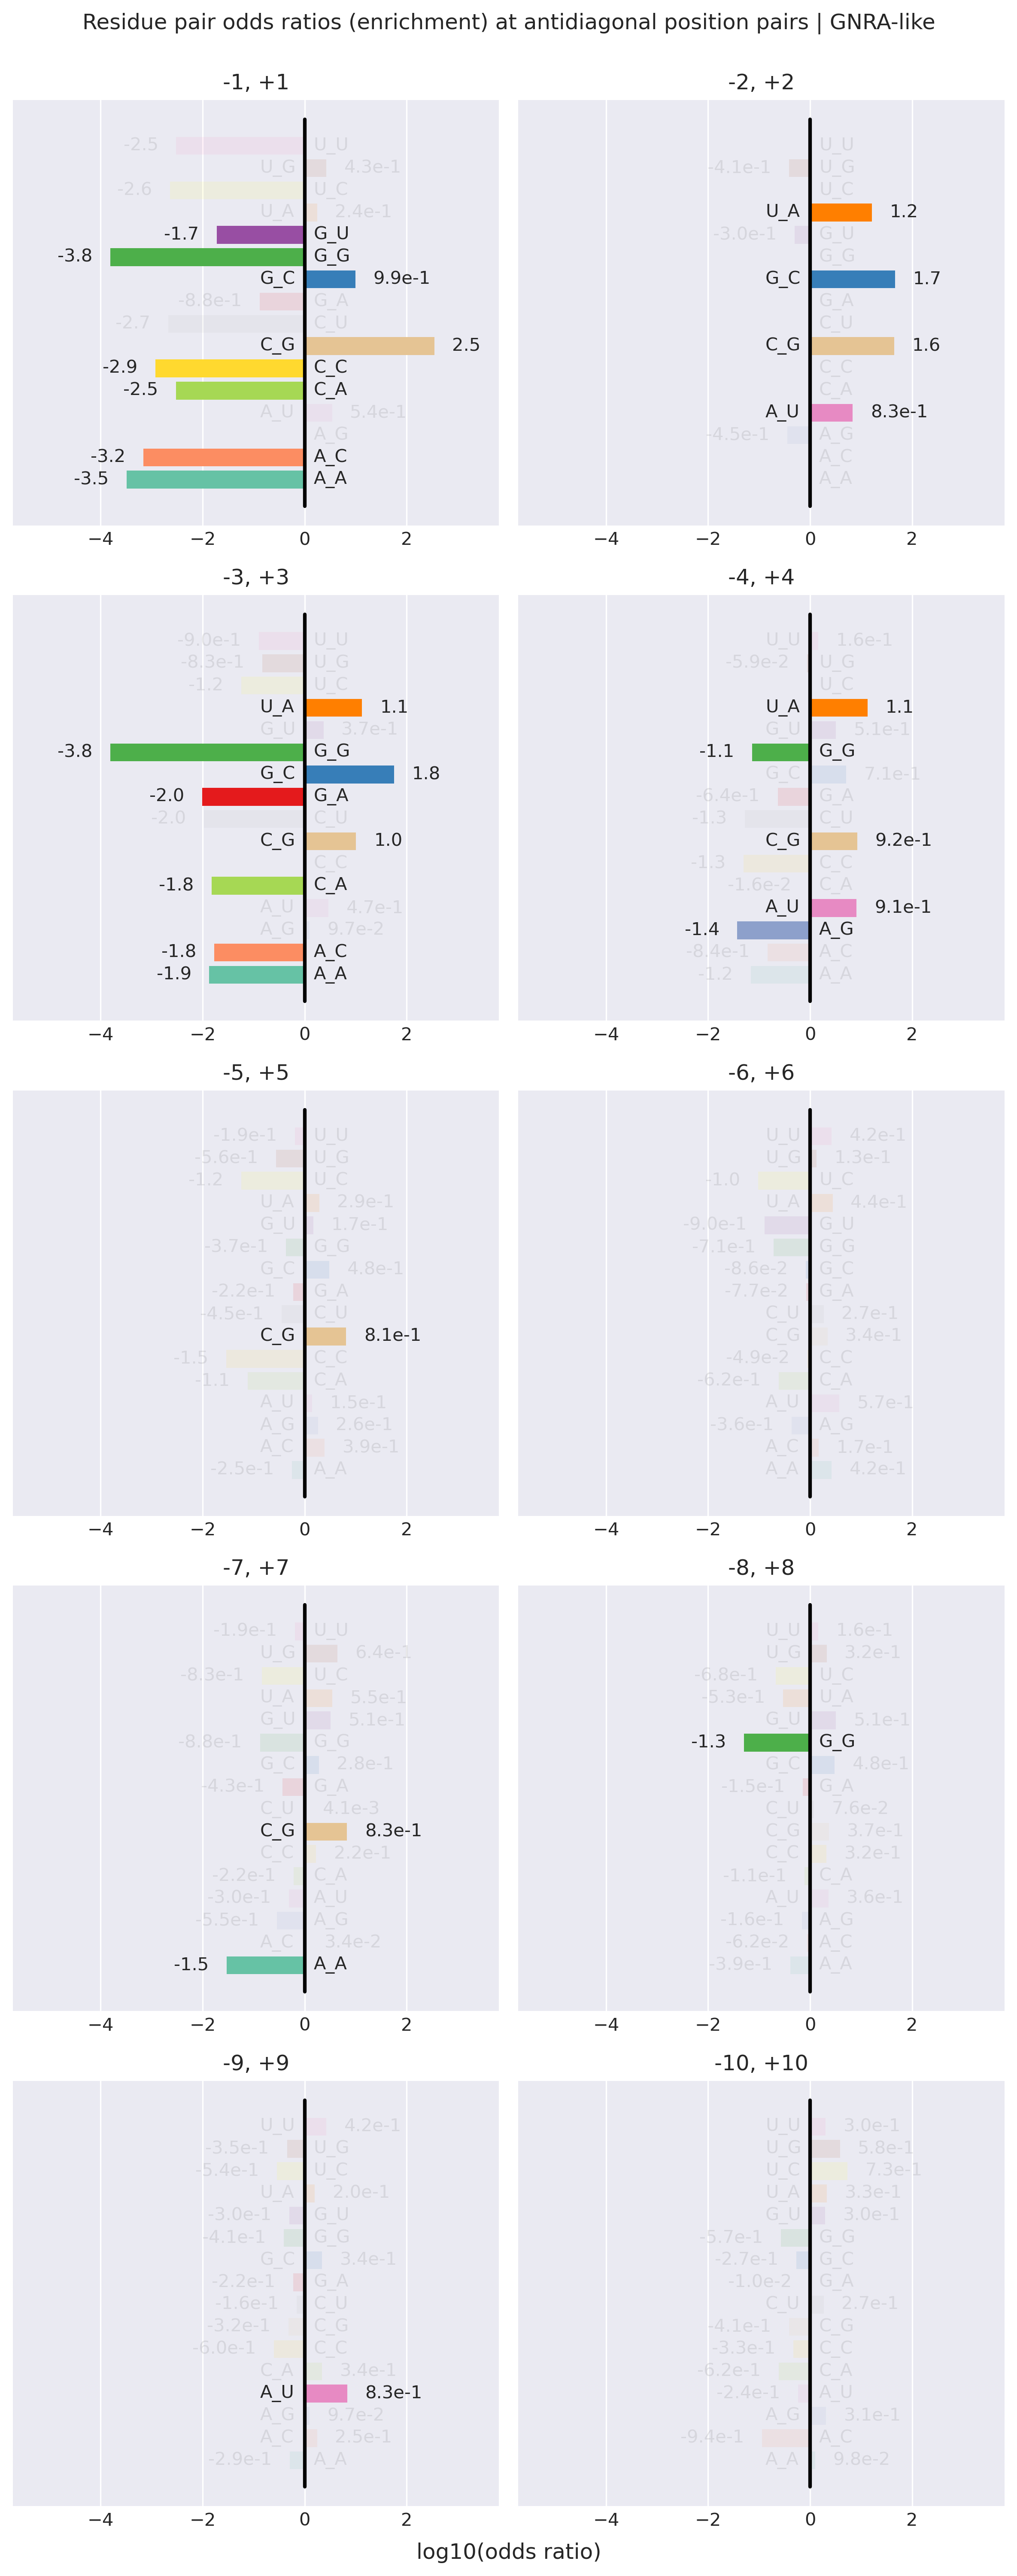

In [22]:
# Antidiagonal

n_cols = 2; n_rows = math.ceil(len(pos_pairs_antid)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), dpi=300)
fig.suptitle(f"Residue pair odds ratios (enrichment) at antidiagonal position pairs | {PLOT_TITLE}", y=1)
plot_pairwise(axes.flatten(), pairwise_scores, show_pos_pairs=pos_pairs_antid)
hide_empty_axes(axes)

fig.tight_layout()
fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_pairwise_respair_v_pospair_antidiagonal.png", bbox_inches='tight', dpi=300)

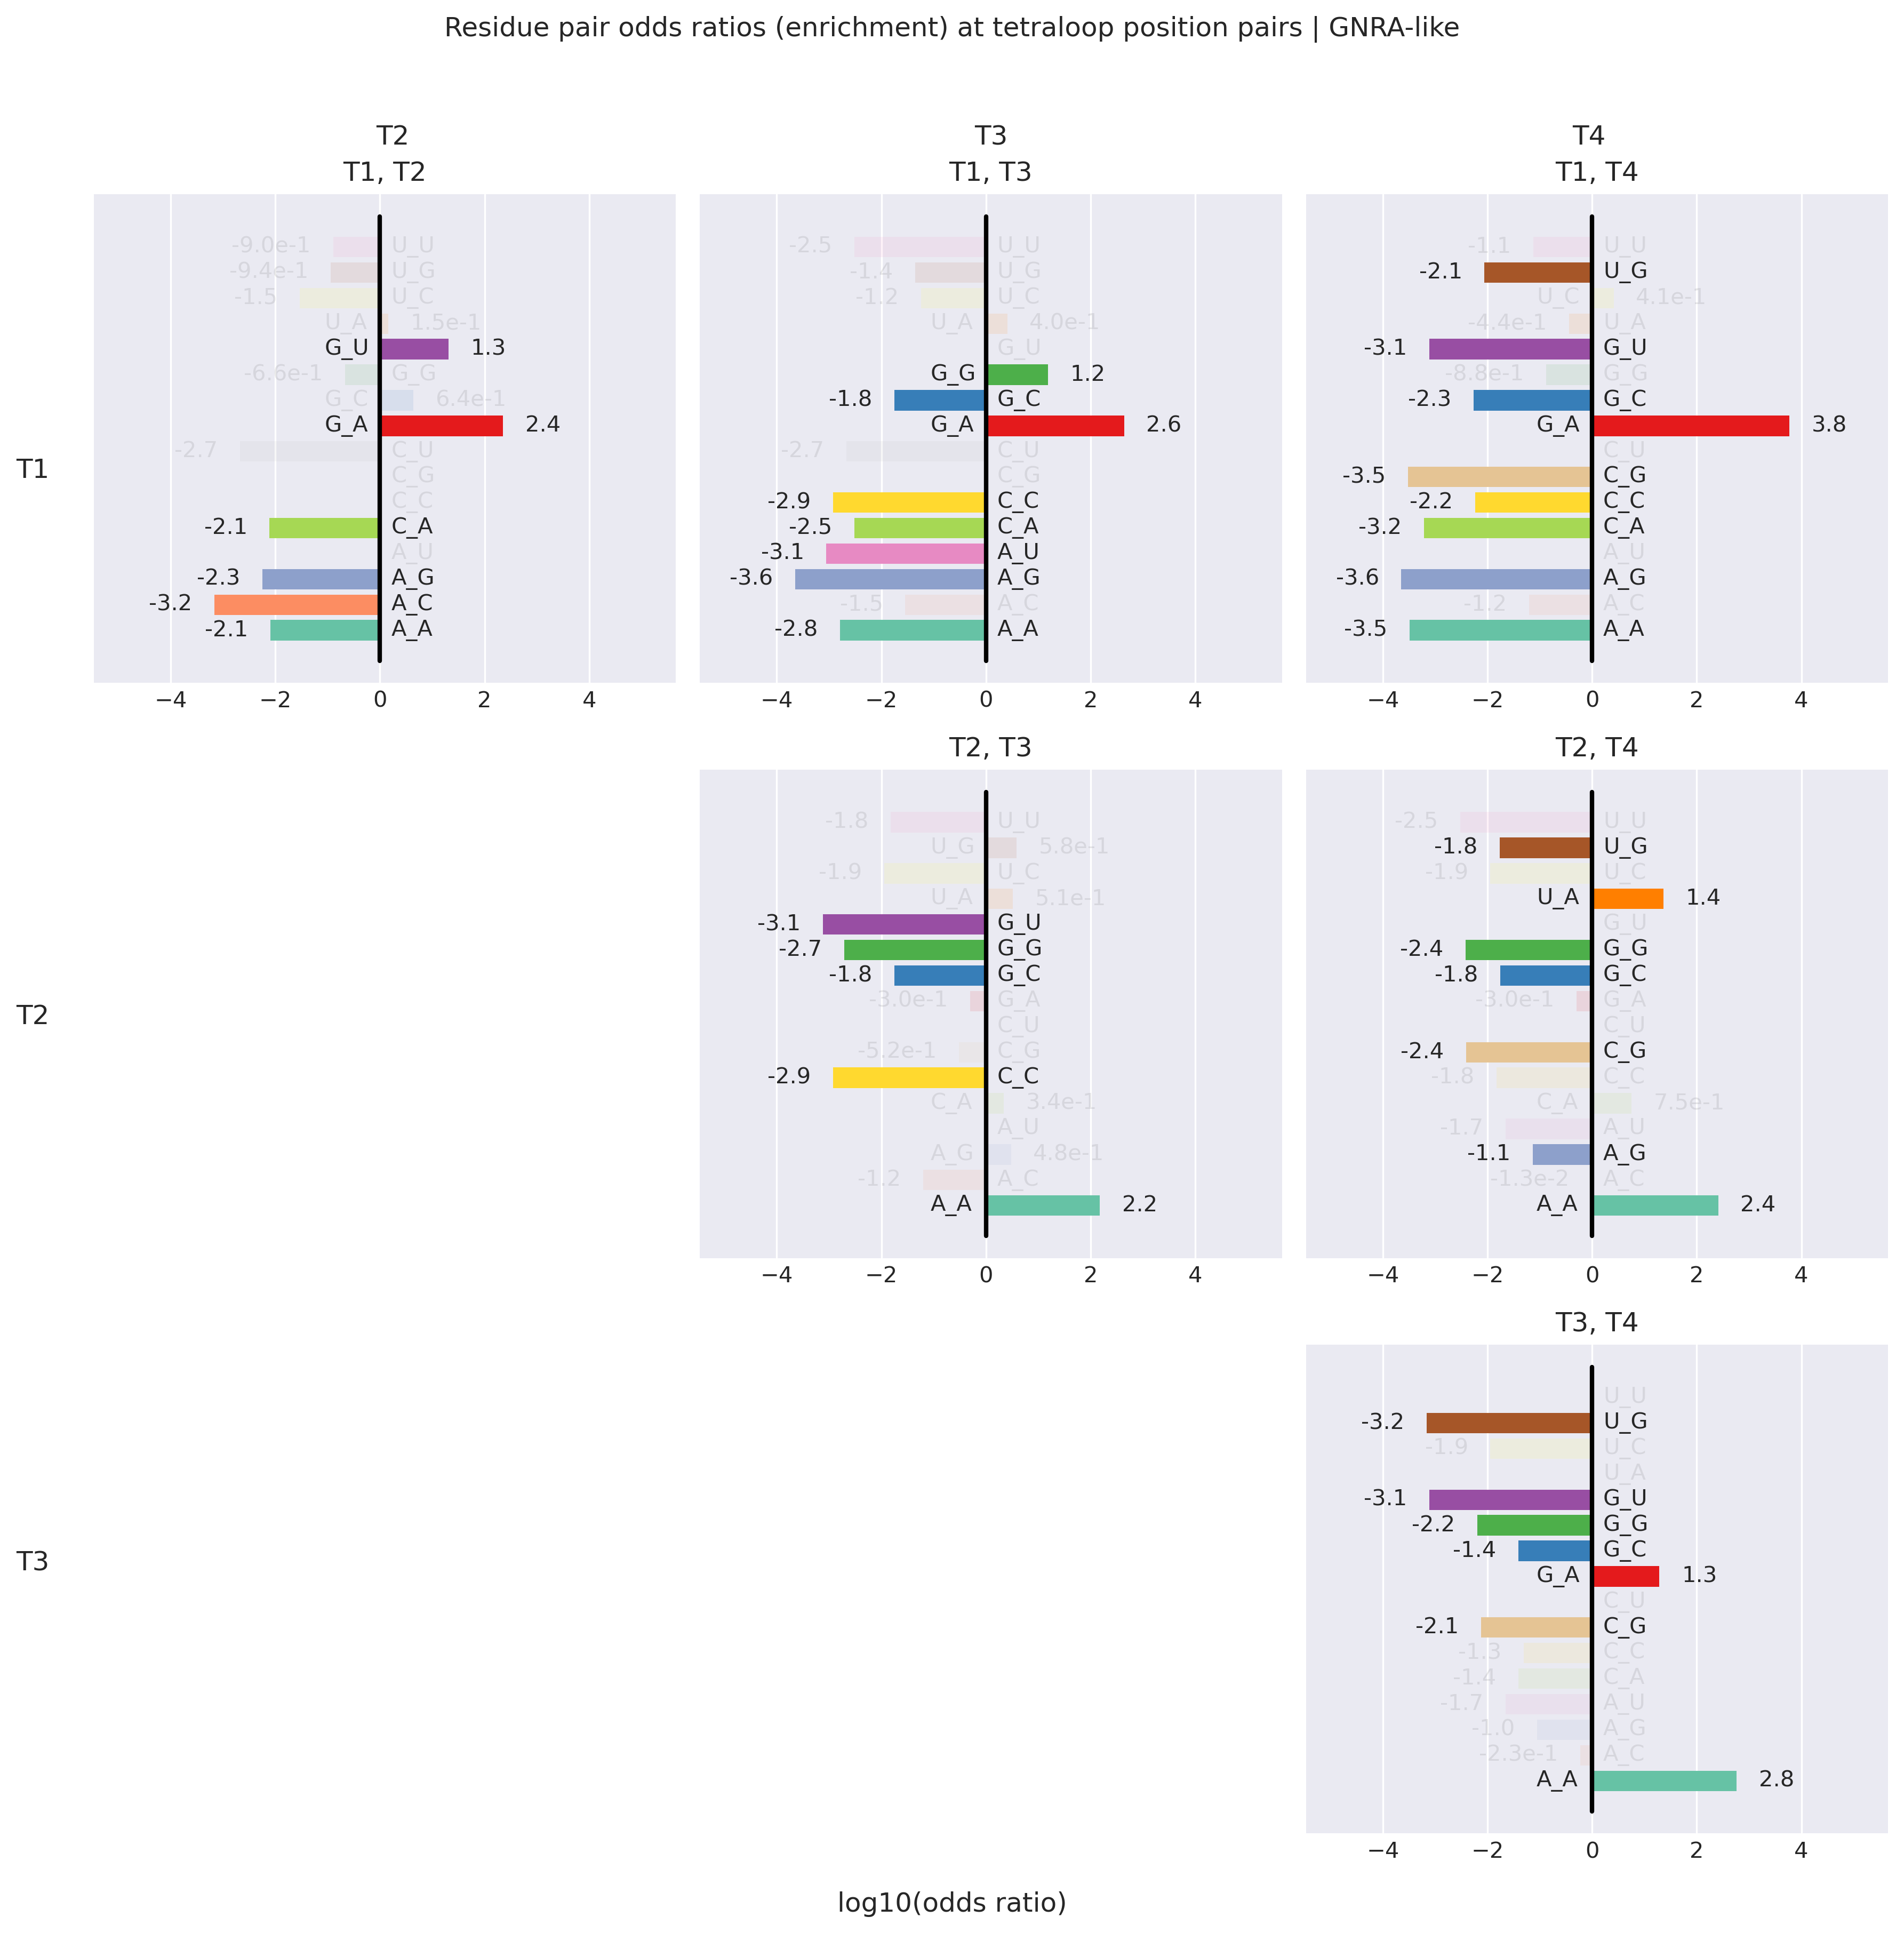

In [23]:
# Tetraloop

fig, axes = plt.subplots(3, 3, figsize=(3*4,3*4), dpi=300)
fig.suptitle(f"Residue pair odds ratios (enrichment) at tetraloop position pairs | {PLOT_TITLE}", y=1)
plot_pairwise(axes.flatten()[ax_coords_tloop], pairwise_scores, show_pos_pairs=pos_pairs_tloop)
hide_empty_axes(axes)
# disable_axes(axes.flatten()[ax_coords_tloop_diag])
add_global_ticks(fig, res_num_labels[tloop_pos+1:tloop_pos+4], res_num_labels[tloop_pos:tloop_pos+3])

fig.tight_layout()
fig.savefig(FIGURES_DIR/f"{FILE_PREFIX}_pairwise_respair_v_pospair_tloop.png", bbox_inches='tight', dpi=300)

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [ ]:
# Unique sequences

generated_tloops = [i for i in fragments_8 if i.clust_id in range(1,45)]

print(f"Set        | {              'Total':<5} | {                          'Unique sequences':<16} | PDB IDs")
print(f"Bottaro    | {          len(tloops):<5} | {          len(get_seqs(tloops, unique=True)):<16} | {len(get_pdb_ids(tloops, unique=True))}")
print(f"Generated  | {len(generated_tloops):<5} | {len(get_seqs(generated_tloops, unique=True)):<16} | {len(get_pdb_ids(generated_tloops, unique=True))}")

In [ ]:
# Missing Tetraloop sequences (found in Bottaro but not in Generated)

tloop_seqs = set([i.res_seq for i in tloops])
tloop_fragment_seqs = set([i.res_seq for i in fragments_8 if i.clust_id != 0])

missing_seqs = tloop_seqs - tloop_fragment_seqs
print(f"Sequences missing from Fragments: {missing_seqs}")
missing_tloops = [i for i in tloops if i.res_seq in missing_seqs]
print(f"{len(missing_tloops)} tetraloops missing from Fragments")

if missing_tloops:
    print(f"{  'Cluster ID':<10} | {'PDB ID':<6} | {  'Sequence'} | {'Residue number'}")
    for i in missing_tloops:
        print(f"{i.clust_id:<10} | {i.pdb_id:<6} | {i.res_seq:<8} | {i.res_nums[0]}")

# Chains

In [ ]:
print(f"{                 'Total'} | {                              'Unique sequences'} | {'PDB IDs'}")
print(f"{len(chains_annotated):<5} | {len(get_seqs(chains_annotated, unique=True)):<16} | {len(get_pdb_ids(chains_annotated, unique=True))}")

In [ ]:
# Chain length distribution

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.set_title("Chain length distribution")
ax.set_xlabel("Length (nt)")
ax.set_ylabel("Number of chains")
ax.set_ylim([0, 2800])

data = [len(i) for i in chains_annotated]
values, _, bars = ax.hist(data, bins = range(0, max(data), 250), rwidth=0.8)
ax.bar_label(bars, labels=[int(i) if i != 0 else "" for i in values], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data), 250))
ax.tick_params(axis='x', rotation=45, length=5, color="#C3C3DA")

fig.savefig(FIGURES_DIR/"chain_lengths.png", bbox_inches='tight', dpi=300)

# TODO add labels at peaks

In [ ]:
# Number of tetraloops per annotated chain
# check the chains with the highest number of tetraloops

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)

ax.set_title("Number of tetraloops per chain")
ax.set_xlabel("Number of tetraloops per chain")
ax.set_ylabel("Number of chains")
ax.set_ylim([0, 1400])
ax.set_xlim([-1,25])

data = [len(i.tloops) for i in chains_annotated]

values, _, bars = ax.hist(data, bins = range(0, max(data)), rwidth=0.8, align="left")
ax.bar_label(bars, labels=[int(i) if i != 0 else "" for i in values], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data)))
ax.set_xticklabels(list(range(1, max(data))) + [""])
ax.grid(which="minor")

fig.savefig(FIGURES_DIR/"tloops_per_chain.png", bbox_inches='tight', dpi=300)

# TODO annotate range with 23s 16s etc.?

# Fragments

## Unique sequences

For a sequence of length 8, the number of unique RNA sequences is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique sequences of length 8 is $764646$.

In [ ]:
# Possible number of unique fragments (assuming each residue is independent) vs. actual number of unique fragments (and expected number of tries to obtain said number)

print(f"{      'Length'} | {   'Total':<7} | {   'Possible':<15} | {          'Expected unique':<15} | {'Actual unique'}")
for seq_len, frags in zip(FRAGMENTS_RANGE, fragments):
    possible_seqs = 4**seq_len
    actual_unique_seqs = len(get_seqs(frags, unique=True))
    expected_unique_seqs = possible_seqs*(1-(1-(1/possible_seqs))**len(frags))
    print(f"{seq_len:<6} | {len(frags):<7} | {possible_seqs:<15} | {round(expected_unique_seqs):<15} | {actual_unique_seqs}")

In [ ]:
# Decoy sizes

decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments]
print("Cluster | " + " | ".join([f"{i:<7}" for i in FRAGMENTS_RANGE]))
print("Decoys  | " + " | ".join([f"{i:<7}" for i in decoys]))

In [ ]:
# Check which decoy sequences also appear as tloops

fragments_set = fragments_8

tloop_seqs = set(get_seqs([i for i in fragments_set if i.clust_id != 0], unique=True))
decoy_seqs = set(get_seqs([i for i in fragments_set if i.clust_id == 0], unique=True))
common_seqs = tloop_seqs.intersection(decoy_seqs)

tloop_frags = len([i for i in fragments_set if i.clust_id != 0])
decoy_frags = len([i for i in fragments_set if i.clust_id == 0])
common_tloop_frags = len([i for i in fragments_set if i.res_seq in common_seqs and i.clust_id != 0])
common_decoy_frags = len([i for i in fragments_set if i.res_seq in common_seqs and i.clust_id == 0])

print("Sequences")
print(f"{       'Tetraloop'} | {           'Decoy':<5} | {'Common'}")
print(f"{len(tloop_seqs):<9} | {   len(decoy_seqs):<5} | {len(common_seqs)}\n")
print("Fragments")
print(f"{   'Set':<9} | {          'Tetraloop'} | {           'Decoy':<8} | {'Total'}")
print(f"{   'All':<9} | {       tloop_frags:<9} | {       decoy_frags:<8} | {tloop_frags + decoy_frags}")
print(f"{'Common':<9} | {common_tloop_frags:<9} | {common_decoy_frags:<8} | {common_tloop_frags + common_decoy_frags}")

# print(f"\n{'':=<45}\n")

# # Print all fragments
# for seq in common_seqs:
#     common_tloop_frags = [i for i in fragments_8 if i.res_seq == seq and i.clust_id != 0]
#     common_decoy_frags = [i for i in fragments_8 if i.res_seq == seq and i.clust_id == 0]
#     print(f"{seq}\n")
    
#     print(f"{               'Tetraloops'} | {'Fragments'}")
#     print(f"{len(common_tloop_frags):<10} | {len(common_decoy_frags)}\n")

#     print(f"{         'Cluster ID'} | {      'PDB ID'} | {      'Chain ID'} | {'Residue number'}")
#     for frag in common_tloop_frags + common_decoy_frags:
#         print(f"{frag.clust_id:<10} | {frag.pdb_id:<6} | {frag.chain_id:<8} | {frag.res_nums[0]}")
#     print(f"\n{'':=<45}\n")

# Clusters

In [ ]:
# Number of fragments per tetraloop cluster

tloop_counts = get_counter_dict([i.clust_id for i in tloops])
tloop_counts = dict(sorted(tloop_counts.items(), key=lambda x:x[0]))
generated_counts = {}
for cluster in range(45):
    generated_counts[cluster] = [len([j for j in i if j.clust_id == cluster]) for i in fragments]

print(f"{'Cluster'} | {  'Bottaro':<7} | " + " | ".join([f"{i:<7}" for i in FRAGMENTS_RANGE]))
print('-'*19 + '-'*10*len(FRAGMENTS_RANGE))
for i in range(45):
    tloop_count = tloop_counts[i] if i != 0 else ''
    print(f"{ i:<7} | {tloop_count:<7} | " + " | ".join([f"{j:<7}" for j in generated_counts[i]]))
    print('-'*19 + '-'*10*len(FRAGMENTS_RANGE))

In [ ]:
# Balance (using Shannon entropy index) 0-1

def balance(classes):
    n_total = sum(classes.values())
    n_classes = len(classes)
    H = -sum([(count/n_total) * log((count/n_total)) for _, count in classes.items()])
    return H/log(n_classes)

print(f"Fragments balance: {balance(get_counter_dict([i.clust_id for i in fragments_8])):.3f}")

print(f"Bottaro tetraloops balance: {balance(get_counter_dict([i.clust_id for i in tloops])):.3f}")
print(f"Generated tetraloops balance: {balance(get_counter_dict([i.clust_id for i in fragments_8 if i.clust_id != 0])):.3f}")

#! class sizes reduced proportionally
#! redundancy reduction has no effect, balance stays the same
#! maybe all clusters have the same proportion of redundancy
#! some clusters more strict

## Fold analysis

In [ ]:
# Folds, as named in Bottaro et al. Table SI1
FOLDS = {1: "GNRA", 3: "GNRA-like", 6: "GNRA-like", 9: "GNRA-like", 25: "GNRA-like", 26: "GNRA-like", 36: "GNRA-like", 40: "GNRA-like", 2: "UNCG", 5: "UNCG-like", 37: "UNCG-like", 44: "UNCG-like", 4: "U-TURN", 7: "7", 8: "8", 10: "10", 11: "4-Stack", 12: "12", 34: "34", 13: "13", 20: "20", 14: "14", 19: "19", 15: "15", 16: "16", 17: "17", 18: "18", 21: "RNYA", 22: "22", 32: "32", 43: "43", 23: "23", 24: "24", 27: "27", 28: "28", 29: "29", 30: "GGUG", 31: "31", 33: "33", 35: "CUUG", 38: "CUUG", 39: "AGNN", 41: "41", 42: "42"}
HEIGHT = 0.4

In [ ]:
def group_folds(data, named_folds=[i for i in FOLDS.values() if not i.isdigit()]):
    clust_ids = get_counter_dict([i.clust_id for i in data])
    folds = dict(zip(named_folds + ["Other"], np.zeros(len(named_folds)+1)))
    for cluster, count in clust_ids.items():
        cluster_name = FOLDS[cluster]
        if cluster_name in named_folds: folds[cluster_name] += count
        else:                           folds["Other"] += count
    folds = dict(reversed(list(folds.items())))
    return folds

In [ ]:
bottaro_folds = group_folds(tloops)
generated_folds = group_folds([i for i in fragments_8 if i.clust_id != 0])

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
ax.set_title("Number of tetraloops per fold")
ax.set_xlabel("Number of tetraloops")
ax.set_ylabel("Fold")
ax.set_xlim([0, 12000])

ax.set_yticks(range(len(bottaro_folds)), labels=bottaro_folds.keys())
bar = ax.barh(range(len(bottaro_folds)), bottaro_folds.values(), height=HEIGHT, align="edge", hatch=HATCHES[0])
ax.bar_label(bar, [int(i) for i in bottaro_folds.values()], padding=5)
bar = ax.barh(range(len(generated_folds)), generated_folds.values(), height=-HEIGHT, align="edge", hatch=HATCHES[1])
ax.bar_label(bar, [int(i) for i in generated_folds.values()], padding=5)

ax.legend(labels=["Bottaro tetraloops", "Generated tetraloops"], loc = "lower right")

fig.savefig(FIGURES_DIR/"tloops_per_fold.png", bbox_inches='tight', dpi=300)

# Training datasets

In [38]:
# train/dev/test ratios and % positive examples

training_data = {}

for dir in os.listdir(TRAINING_DATA_DIR):
    if os.path.isfile(TRAINING_DATA_DIR/dir): continue
    if dir[-1] == "T": continue

    data_dict = {}
    total = 0
    positives = 0

    for file in os.listdir(TRAINING_DATA_DIR/dir):
        if file.endswith('.csv') or file.endswith('.npz'): continue

        name = file.split("_")[0]
        labels = np.load(TRAINING_DATA_DIR/dir/file)
        data_dict[name] = len(labels)
        
        total += len(labels)
        positives += np.count_nonzero(labels == 1)
    
    data_dict["total"] = total
    data_dict["positive"] = positives
    data_dict = dict(sorted(zip(data_dict.keys(), data_dict.values())))

    data_name = "_".join(dir.split("_")[:2])
    training_data[data_name] = data_dict

training_data = dict(sorted(training_data.items(), key=lambda x: x[0]))
print(f"{'Dataset':<15} | {     'Train':<5} | {     'Dev':<4} | {     'Test':<4} | {     'Total':<5} | {'Positive (%)'}")
print('-'*60)
for key, val in training_data.items():
    pos_percent = val['positive']/val['total']*100
    print(f"{  key:<15} | {val['train']:<5} | {val['dev']:<4} | {val['test']:<4} | {val['total']:<5} | {val['positive']} ({pos_percent:.2f})")
    # print('-'*60)

Dataset         | Train | Dev  | Test | Total | Positive (%)
------------------------------------------------------------
folds_10        | 37132 | 12390 | 12394 | 61916 | 269 (0.43)
folds_12        | 40410 | 13482 | 13488 | 67380 | 334 (0.50)
folds_14        | 41922 | 13984 | 13992 | 69898 | 350 (0.50)
folds_16        | 43026 | 14354 | 14361 | 71741 | 365 (0.51)
folds_18        | 43940 | 14657 | 14667 | 73264 | 374 (0.51)
folds_20        | 44712 | 14916 | 14922 | 74550 | 376 (0.50)
folds_22        | 45395 | 15142 | 15150 | 75687 | 389 (0.51)
folds_24        | 46018 | 15350 | 15356 | 76724 | 384 (0.50)
folds_8         | 22465 | 7500 | 7504 | 37469 | 175 (0.47)
gnra_10         | 259   | 88   | 89   | 436   | 245 (56.19)
gnra_12         | 318   | 107  | 108  | 533   | 305 (57.22)
gnra_14         | 328   | 111  | 111  | 550   | 317 (57.64)
gnra_16         | 334   | 113  | 114  | 561   | 330 (58.82)
gnra_18         | 339   | 115  | 116  | 570   | 336 (58.95)
gnra_20         | 341   | 115  